In [1]:
%matplotlib inline

In [1]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# Modified for project porpuses by: Cristian Gonzalez-Colin
# License: BSD 3 clause

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from imblearn.over_sampling import SMOTE, ADASYN


In [29]:
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [53]:
tpm_cancer = pd.read_table("data/inputfiles/GSE131512_cancerTPM.txt")
tpm_healthy = pd.read_table("data/inputfiles/GSE131512_normalTPM.txt")
metadata = pd.read_table("data/inputfiles/GSE131512_metaData.csv", sep=",", index_col=0)
####
genes = pd.read_table('DEgenes.txt', header=None)[0].values
tpm_healthy = tpm_healthy.transpose()
tpm_cancer = tpm_cancer.transpose()
tpm = pd.concat([tpm_healthy, tpm_cancer])
#tpm = tpm.merge(metadata.iloc[:,:2], left_index=True, right_index=True)


/Users/cgonzalez/miniconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/cgonzalez/miniconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/cgonzalez/miniconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/cgonzalez/miniconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/cgonzalez/miniconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/cgonzalez/miniconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear

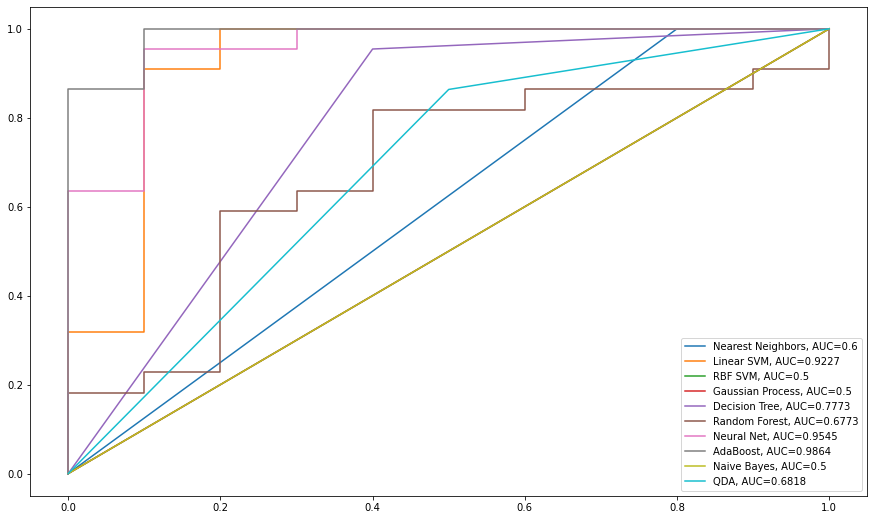

In [54]:

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

features = genes
X = tpm[features]
y = [-1]*32 + [1]*96

metrics = {}

figure = plt.figure(figsize=(15, 9))
i = 1

# preprocess dataset, split into training and test part
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

i += 1
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    results = cross_validation(clf, X_train, y_train, 5)
    #score = clf.score(X_test, y_test)
    metrics[name] = results
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = round(roc_auc_score(y_test, y_pred), 4)
    plt.plot(fpr,tpr,label=name + ", AUC="+str(auc))
    plt.legend()
    

In [46]:
metrics

{'Nearest Neighbors': {'Training Accuracy scores': array([0.81578947, 0.81818182, 0.80519481, 0.77922078, 0.81818182]),
  'Mean Training Accuracy': 80.73137388926864,
  'Training Precision scores': array([1., 1., 1., 1., 1.]),
  'Mean Training Precision': 1.0,
  'Training Recall scores': array([0.76271186, 0.76271186, 0.74576271, 0.71186441, 0.76666667]),
  'Mean Training Recall': 0.7499435028248588,
  'Training F1 scores': array([0.86538462, 0.86538462, 0.85436893, 0.83168317, 0.86792453]),
  'Mean Training F1 Score': 0.8569491718853568,
  'Validation Accuracy scores': array([0.7       , 0.52631579, 0.52631579, 0.42105263, 0.47368421]),
  'Mean Validation Accuracy': 52.94736842105263,
  'Validation Precision scores': array([0.8       , 0.71428571, 0.75      , 0.83333333, 0.7       ]),
  'Mean Validation Precision': 0.7595238095238095,
  'Validation Recall scores': array([0.8       , 0.66666667, 0.6       , 0.33333333, 0.5       ]),
  'Mean Validation Recall': 0.5800000000000001,
  'Va

In [47]:
for i in metrics.keys():
    print(i, metrics[i]['Mean Training Accuracy'], metrics[i]['Mean Validation Accuracy'])
    print(i, metrics[i]['Mean Training Precision'], metrics[i]['Mean Validation Precision'])
    print(i, metrics[i]['Mean Training Recall'], metrics[i]['Mean Validation Recall'])
    print(i, metrics[i]['Mean Validation F1 Score'], metrics[i]['Mean Validation F1 Score'])

Nearest Neighbors 80.73137388926864 52.94736842105263
Nearest Neighbors 1.0 0.7595238095238095
Nearest Neighbors 0.7499435028248588 0.5800000000000001
Nearest Neighbors 0.6431691297208538 0.6431691297208538
Linear SVM 78.12371838687628 76.05263157894737
Linear SVM 0.7790766843398422 0.7687134502923978
Linear SVM 1.0 0.9866666666666667
Linear SVM 0.863763687293099 0.863763687293099
RBF SVM 100.0 77.10526315789473
RBF SVM 1.0 0.7710526315789473
RBF SVM 1.0 1.0
RBF SVM 0.8705373058314235 0.8705373058314235
Gaussian Process 77.08475734791526 77.10526315789473
Gaussian Process 0.7708475734791526 0.7710526315789473
Gaussian Process 1.0 1.0
Gaussian Process 0.8705373058314235 0.8705373058314235
Decision Tree 94.25837320574162 63.421052631578945
Decision Tree 0.9412386132374817 0.7626092861386978
Decision Tree 0.99 0.7695238095238095
Decision Tree 0.7603136805723012 0.7603136805723012
Random Forest 80.98427887901572 77.10526315789473
Random Forest 0.8025076853816966 0.7710526315789473
Random F

In [16]:
0.6875
0.84375
0.6875
0.3125
0.96875
0.6875
0.875
0.9375
0.78125
0.625

,ENSG00000278677,ENSG00000173621,ENSG00000229043,ENSG00000252336,ENSG00000258394
N1,0.0,2.825785,11.975004,0.000000,0.000000
N2,0.0,3.075521,0.000000,0.000000,0.000000
N3,0.0,8.605233,0.000000,0.000000,0.000000
N4,0.0,0.000000,0.000000,0.000000,76.825504
N5,0.0,15.500104,0.000000,0.000000,85.115134
...,...,...,...,...,...
C92,0.0,6.372830,0.000000,0.000000,0.000000
C93,0.0,0.000000,19.223853,0.000000,74.730397
C94,0.0,3.575665,5.050940,0.000000,0.000000
C95,0.0,0.000000,5.557297,946.868796,43.206634
